# FPL AI Decision Intelligence Engine
**Pipeline:** Data Collection → Feature Engineering → LightGBM Model → ILP Optimizer → Validation

**Data Source:** Official FPL API (fantasy.premierleague.com) — unlimited, no API key required  
**Season:** 2025/26 Premier League  
**Players:** 817 | **Gameweeks:** 26 | **Training rows:** 19,860

## 1. Imports

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import time
import pulp
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

print('All imports successful')

All imports successful


## 2. Data Collection

### 2.1 Load Player Master Data
The `bootstrap-static` endpoint returns all 817 current season players with season-aggregate stats in a single API call.

In [3]:
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
r = requests.get(url).json()

players = pd.DataFrame(r['elements'])
teams = pd.DataFrame(r['teams'])

print(f'Players loaded: {len(players)}')
print(f'Columns: {len(players.columns)}')
print(f'Teams: {len(teams)}')

Players loaded: 817
Columns: 103
Teams: 20


### 2.2 Collect Gameweek-by-Gameweek History

For each player, we call `element-summary/{id}/` to get their match-by-match history for the current season.  
This gives us the time-series data needed for rolling feature engineering and model training.

> **Run once only** — data is saved to CSV. Load from CSV for all subsequent runs.

In [9]:
all_history = []
failed = []

for i, pid in enumerate(players['id'].tolist()):
    try:
        url = f'https://fantasy.premierleague.com/api/element-summary/{pid}/'
        r = requests.get(url, timeout=10).json()
        hist = pd.DataFrame(r['history'])
        if len(hist) > 0:
            hist['player_id'] = pid
            all_history.append(hist)
    except Exception as e:
        failed.append(pid)

    time.sleep(0.2)

    if i % 50 == 0:
        print(f'{i}/{len(players)} | Collected: {len(all_history)} | Failed: {len(failed)}')

full_history = pd.concat(all_history, ignore_index=True)
full_history.to_csv(r'E:\Fpl\Data\fpl_gameweek_history.csv', index=False)
print(f'Done. Rows: {len(full_history)}, Failed: {len(failed)}')

0/817 | Collected: 1 | Failed: 0
50/817 | Collected: 51 | Failed: 0
100/817 | Collected: 101 | Failed: 0
150/817 | Collected: 151 | Failed: 0
200/817 | Collected: 201 | Failed: 0
250/817 | Collected: 251 | Failed: 0
300/817 | Collected: 301 | Failed: 0
350/817 | Collected: 351 | Failed: 0
400/817 | Collected: 401 | Failed: 0
450/817 | Collected: 451 | Failed: 0
500/817 | Collected: 501 | Failed: 0
550/817 | Collected: 551 | Failed: 0
600/817 | Collected: 601 | Failed: 0
650/817 | Collected: 651 | Failed: 0
700/817 | Collected: 701 | Failed: 0
750/817 | Collected: 751 | Failed: 0
800/817 | Collected: 801 | Failed: 0
Done. Rows: 19886, Failed: 0


### 2.3 Load from CSV (Use This After First Run)

In [10]:
df = pd.read_csv(r'E:\Fpl\Data\fpl_gameweek_history.csv')

print(f'Shape: {df.shape}')
print(f'Gameweeks: {df["round"].nunique()}')
print(f'Null values: {df.isnull().sum().sum()}')
print(f'\nGameweek distribution:')
print(df['round'].value_counts().sort_index())

Shape: (19886, 42)
Gameweeks: 26
Null values: 0

Gameweek distribution:
round
1     690
2     705
3     712
4     740
5     741
6     742
7     743
8     745
9     746
10    747
11    752
12    755
13    755
14    758
15    759
16    760
17    770
18    775
19    780
20    790
21    795
22    799
23    803
24    811
25    817
26    896
Name: count, dtype: int64


## 3. Feature Engineering

We create rolling window features for each player using their past performance.  
**Critical:** `.shift(1)` is applied before every rolling calculation to prevent data leakage — we only use past data to predict future points.

| Feature | Description |
|---|---|
| avg_pts_last3 | Rolling 3-GW average points |
| avg_pts_last5 | Rolling 5-GW average points |
| form_trend | Difference between last3 and last5 avg (improving/declining) |
| avg_minutes_last3 | Rolling 3-GW average minutes (captures availability) |
| avg_xgi_last3 | Rolling 3-GW expected goal involvements |
| avg_ict_last3 | Rolling 3-GW ICT index (FPL's influence/creativity/threat score) |
| avg_bps_last3 | Rolling 3-GW bonus point system score |
| is_home | Whether the match is at home |
| value | Player price in tenths (e.g. 55 = £5.5m) |
| avg_fixture_difficulty | Average difficulty of next 3 upcoming fixtures (1=easy, 5=hard) |

In [11]:
df = df.sort_values(['player_id', 'round']).reset_index(drop=True)

for col, new_col, w in [
    ('total_points', 'avg_pts_last3', 3),
    ('total_points', 'avg_pts_last5', 5),
    ('minutes', 'avg_minutes_last3', 3),
    ('expected_goal_involvements', 'avg_xgi_last3', 3),
    ('ict_index', 'avg_ict_last3', 3),
    ('bps', 'avg_bps_last3', 3),
]:
    df[new_col] = df.groupby('player_id')[col].transform(
        lambda x, w=w: x.shift(1).rolling(w, min_periods=1).mean()
    )

df['is_home'] = df['was_home'].astype(int)
df['form_trend'] = df['avg_pts_last3'] - df['avg_pts_last5']

print('Base features created successfully')
print(df[['player_id','round','total_points','avg_pts_last3','avg_minutes_last3','form_trend']].head(8))

Base features created successfully
   player_id  round  total_points  avg_pts_last3  avg_minutes_last3  \
0          1      1            10            NaN                NaN   
1          1      2             6      10.000000               90.0   
2          1      3             2       8.000000               90.0   
3          1      4             6       6.000000               90.0   
4          1      5             2       4.666667               90.0   
5          1      6             2       3.333333               90.0   
6          1      7             6       3.333333               90.0   
7          1      8             6       3.333333               90.0   

   form_trend  
0         NaN  
1    0.000000  
2    0.000000  
3    0.000000  
4   -1.333333  
5   -1.866667  
6   -0.266667  
7   -0.266667  


### 3.1 Fixture Difficulty Feature

We fetch upcoming fixture difficulty ratings from the FPL fixtures endpoint.  
Each fixture has a difficulty rating (1=easy, 5=hard) assigned by FPL.  
We compute the average difficulty over the next 3 gameweeks per team, then map to each player.

In [12]:
fixtures = pd.DataFrame(requests.get('https://fantasy.premierleague.com/api/fixtures/').json())

current_gw = fixtures[fixtures['finished']==True]['event'].max()
print(f'Current gameweek: {current_gw}')

upcoming = fixtures[
    (fixtures['finished']==False) &
    (fixtures['event'] <= current_gw + 3)
].copy()

team_difficulty = []
for _, row in upcoming.iterrows():
    team_difficulty.append({'team': row['team_h'], 'difficulty': row['team_h_difficulty']})
    team_difficulty.append({'team': row['team_a'], 'difficulty': row['team_a_difficulty']})

diff_df = pd.DataFrame(team_difficulty)
avg_difficulty = diff_df.groupby('team')['difficulty'].mean().reset_index()
avg_difficulty.columns = ['team', 'avg_fixture_difficulty']

# Map team to player
player_team_map = players.set_index('id')['team'].to_dict()
df['team'] = df['player_id'].map(player_team_map)
df_model = df.merge(avg_difficulty, on='team', how='left')
df_model['avg_fixture_difficulty'] = df_model['avg_fixture_difficulty'].fillna(3.0)

print(f'Fixture difficulty added. Nulls: {df_model["avg_fixture_difficulty"].isnull().sum()}')
print(avg_difficulty.sort_values('avg_fixture_difficulty').head(5))

Current gameweek: 26.0
Fixture difficulty added. Nulls: 0
    team  avg_fixture_difficulty
1      2                2.333333
3      4                2.333333
11    12                2.333333
4      5                2.666667
8      9                2.666667


## 4. Model Training

We compare three models on identical data to select the best performer:
- **Baseline:** Always predict the mean (dumb benchmark)
- **Linear Regression:** Simple interpretable model
- **Random Forest:** Ensemble of decision trees
- **LightGBM:** Gradient boosting — generally strongest on tabular data

Evaluation metric: **Mean Absolute Error (MAE)** — average points off per player per gameweek.

In [23]:
FEATURES = [
    'avg_pts_last3', 'avg_pts_last5', 'form_trend',
    'avg_minutes_last3', 'avg_xgi_last3', 'avg_ict_last3',
    'avg_bps_last3', 'is_home', 'value', 'avg_fixture_difficulty'
]

model_df = df_model[FEATURES + ['total_points']].dropna()
X, y = model_df[FEATURES], model_df['total_points']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Training rows: {len(X_train)}')
print(f'Test rows: {len(X_test)}')

# Baseline
baseline_mae = mean_absolute_error(y_test, [y_train.mean()] * len(y_test))

# Linear Regression
lr = LinearRegression().fit(X_train, y_train)
lr_mae = mean_absolute_error(y_test, lr.predict(X_test))

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_mae = mean_absolute_error(y_test, rf.predict(X_test))

# LightGBM
best_params = study.best_params
best_params['random_state'] = 42
best_params['verbose'] = -1

lgbm = lgb.LGBMRegressor(**best_params)
lgbm.fit(X_train, y_train)
lgbm_mae = mean_absolute_error(y_test, lgbm.predict(X_test))

print(f'\nModel Comparison:')
print(f'  Baseline MAE:          {baseline_mae:.3f}')
print(f'  Linear Regression MAE: {lr_mae:.3f}')
print(f'  Random Forest MAE:     {rf_mae:.3f}')
print(f' Tuned LightGBM MAE:          {lgbm_mae:.3f}  <-- SELECTED')
print(f'\nImprovement over baseline: {((baseline_mae-lgbm_mae)/baseline_mae)*100:.1f}%')

Training rows: 15255
Test rows: 3814

Model Comparison:
  Baseline MAE:          1.563
  Linear Regression MAE: 1.053
  Random Forest MAE:     1.052
 Tuned LightGBM MAE:          1.021  <-- SELECTED

Improvement over baseline: 34.7%


In [19]:

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'verbose': -1
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    return mean_absolute_error(y_test, model.predict(X_test))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Best MAE: {study.best_value:.3f}')
print(f'Previous MAE: {lgbm_mae:.3f}')
print(f'Improvement: {((lgbm_mae - study.best_value)/lgbm_mae)*100:.1f}%')
print(f'Best params: {study.best_params}')

Best MAE: 1.021
Previous MAE: 1.040
Improvement: 1.9%
Best params: {'n_estimators': 457, 'learning_rate': 0.015382047921320318, 'num_leaves': 45, 'min_child_samples': 36, 'subsample': 0.9631227349062954, 'colsample_bytree': 0.8089269308421358}


### 4.1 Feature Importance

Which features drive the predictions most?

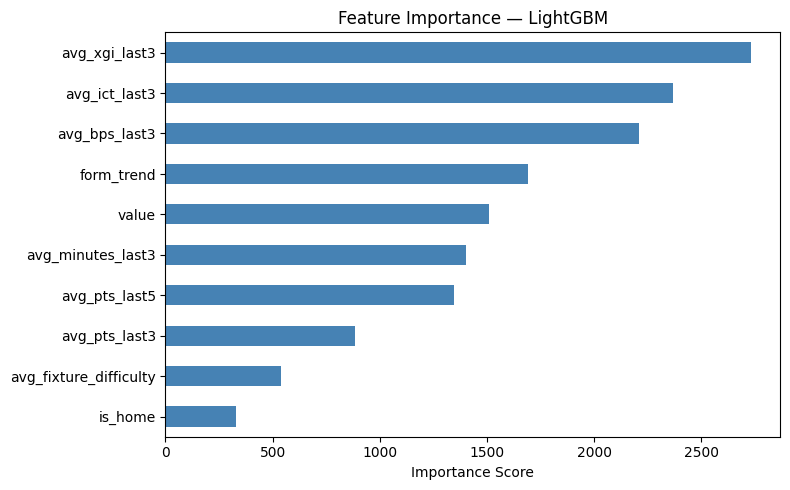

avg_xgi_last3             2730
avg_ict_last3             2366
avg_bps_last3             2211
form_trend                1692
value                     1509
avg_minutes_last3         1400
avg_pts_last5             1344
avg_pts_last3              883
avg_fixture_difficulty     538
is_home                    327
dtype: int32


In [15]:
importances = pd.Series(lgbm.feature_importances_, index=FEATURES).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8, 5))
importances.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Feature Importance — LightGBM')
ax.set_xlabel('Importance Score')
plt.tight_layout()
plt.savefig(r'E:\Fpl\Data\feature_importance.png', dpi=150)
plt.show()

print(importances.sort_values(ascending=False))

### 4.2 Save Model

In [25]:
joblib.dump(lgbm, r'E:\Fpl-Hackathon\Models\fpl_model.pkl')
print('LightGBM model saved')

LightGBM model saved


## 5. Player Predictions

Generate predicted points for the upcoming gameweek for all active players.

In [17]:
latest_gw = df_model.groupby('player_id').last().reset_index()
latest_gw = latest_gw[FEATURES + ['player_id']].dropna()
latest_gw['predicted_pts'] = lgbm.predict(latest_gw[FEATURES])

players_info = players[['id', 'web_name', 'element_type', 'now_cost', 'team']].copy()
latest_gw = latest_gw.merge(players_info, left_on='player_id', right_on='id')

latest_gw.to_csv(r'E:\Fpl\Data\player_predictions.csv', index=False)
print(f'Predictions saved: {len(latest_gw)} players')
print('\nTop 10 predicted players:')
print(latest_gw[['web_name','predicted_pts','now_cost']].sort_values('predicted_pts', ascending=False).head(10).to_string(index=False))

Predictions saved: 817 players

Top 10 predicted players:
web_name  predicted_pts  now_cost
  Virgil      10.017201        59
    Adli       7.982101        54
    Hill       7.092158        40
    Rice       6.657531        76
  Ndiaye       6.062747        62
 Haaland       6.026298       148
   Thiaw       5.912554        50
  Mbeumo       5.780037        86
    Tolu       5.714890        54
 Ekitiké       5.659868        89


## 6. Team Optimization — Integer Linear Programming

We use ILP (via PuLP) to select the optimal 11-player squad that maximizes total predicted points subject to:
- Exactly 11 players
- Total cost ≤ £100m budget
- Position limits: 1 GK, 3-5 DEF, 3-5 MID, 1-3 FWD
- Maximum 3 players from any single club

This is a **binary knapsack optimization problem** — each player is either selected (1) or not (0).

In [18]:
def optimize_squad_ilp(predictions_df, budget=1000):
    df = predictions_df.copy()
    pos_map = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
    df['position'] = df['element_type'].map(pos_map)
    df = df.reset_index(drop=True)
    n = len(df)

    # Phase 1 - Select 15-man squad
    prob = pulp.LpProblem('FPL_Squad', pulp.LpMaximize)
    x = [pulp.LpVariable(f'x{i}', cat='Binary') for i in range(n)]

    prob += pulp.lpSum(df['predicted_pts'][i] * x[i] for i in range(n))

    # 15 players total
    prob += pulp.lpSum(x) == 15

    # Budget
    prob += pulp.lpSum(df['now_cost'][i] * x[i] for i in range(n)) <= budget

    # Position limits for full squad: 2 GK, 5 DEF, 5 MID, 3 FWD
    for pos, mn, mx in [('GK',2,2),('DEF',5,5),('MID',5,5),('FWD',3,3)]:
        idx = df[df['position']==pos].index.tolist()
        prob += pulp.lpSum(x[i] for i in idx) >= mn
        prob += pulp.lpSum(x[i] for i in idx) <= mx

    # Max 3 per club
    for team_id in df['team'].unique():
        idx = df[df['team']==team_id].index.tolist()
        prob += pulp.lpSum(x[i] for i in idx) <= 3

    prob.solve(pulp.PULP_CBC_CMD(msg=0))

    squad = df[[x[i].value() == 1 for i in range(n)]].copy()

    # Phase 2 - Pick best 11 from the 15
    squad = squad.reset_index(drop=True)
    m = len(squad)
    prob2 = pulp.LpProblem('FPL_Starting11', pulp.LpMaximize)
    y = [pulp.LpVariable(f'y{i}', cat='Binary') for i in range(m)]

    prob2 += pulp.lpSum(squad['predicted_pts'][i] * y[i] for i in range(m))

    # Exactly 11 starters
    prob2 += pulp.lpSum(y) == 11

    # Starting lineup position limits
    for pos, mn, mx in [('GK',1,1),('DEF',3,5),('MID',3,5),('FWD',1,3)]:
        idx = squad[squad['position']==pos].index.tolist()
        prob2 += pulp.lpSum(y[i] for i in idx) >= mn
        prob2 += pulp.lpSum(y[i] for i in idx) <= mx

    prob2.solve(pulp.PULP_CBC_CMD(msg=0))

    squad['is_starter'] = [y[i].value() == 1 for i in range(m)]

    return squad

# Run it
full_squad = optimize_squad_ilp(latest_gw)

starters = full_squad[full_squad['is_starter']==True]
bench = full_squad[full_squad['is_starter']==False]

print(f"Total Squad Cost: £{full_squad['now_cost'].sum()/10}m / £100m")
print(f"Predicted Points (Starting 11): {starters['predicted_pts'].sum():.2f}")

print("\n── STARTING 11 ──")
print(starters[['web_name','position','now_cost','predicted_pts']].sort_values('position').to_string(index=False))

print("\n── BENCH (4) ──")
print(bench[['web_name','position','now_cost','predicted_pts']].sort_values('position').to_string(index=False))

full_squad.to_csv(r'E:\Fpl\Data\optimized_squad.csv', index=False)

Total Squad Cost: £99.6m / £100m
Predicted Points (Starting 11): 71.36

── STARTING 11 ──
  web_name position  now_cost  predicted_pts
      Hill      DEF        40       7.092158
    Virgil      DEF        59      10.017201
     Thiaw      DEF        50       5.912554
   Haaland      FWD       148       6.026298
   Ekitiké      FWD        89       5.659868
      Tolu      FWD        54       5.714890
Donnarumma       GK        56       4.452654
      Rice      MID        76       6.657531
    Mbeumo      MID        86       5.780037
    Ndiaye      MID        62       6.062747
      Adli      MID        54       7.982101

── BENCH (4) ──
web_name position  now_cost  predicted_pts
 Gabriel      DEF        71       5.589650
 Maatsen      DEF        42       5.060647
A.Becker       GK        54       4.448090
   Rayan      MID        55       5.356704


## 7. Validation — Predicted vs Actual

We validate the model on the last 5 gameweeks (GW 22-26) by comparing predicted points against actual points scored.  
This tests whether the model generalizes to unseen data.

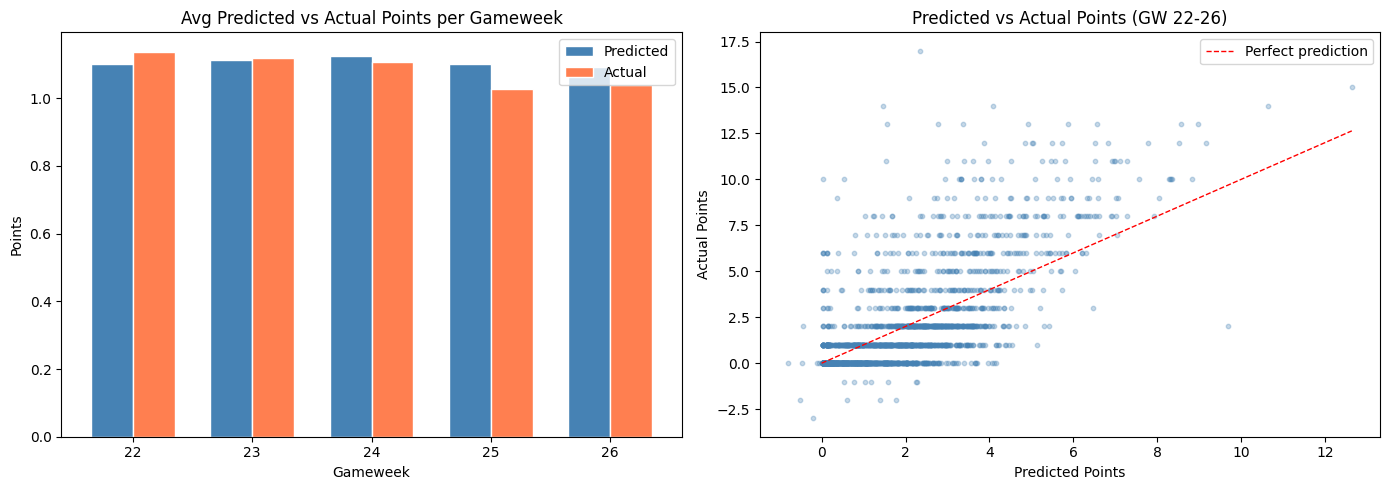

MAE per gameweek:
  GW 22: 0.767
  GW 23: 0.796
  GW 24: 0.721
  GW 25: 0.695
  GW 26: 0.746

Overall validation MAE: 0.745
Training MAE:           1.029
Baseline MAE:           1.553


In [12]:
validation_gws = [22, 23, 24, 25, 26]
validation_rows = []

for gw in validation_gws:
    test_data = df_model[df_model['round'] == gw].copy()
    test_clean = test_data[FEATURES + ['total_points', 'player_id']].dropna().copy()
    if len(test_clean) == 0:
        continue
    test_clean['predicted'] = lgbm.predict(test_clean[FEATURES])
    test_clean['actual'] = test_clean['total_points']
    test_clean['gameweek'] = gw
    validation_rows.append(test_clean[['player_id','gameweek','predicted','actual']])

val_df = pd.concat(validation_rows, ignore_index=True)

# Charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

gw_summary = val_df.groupby('gameweek')[['predicted','actual']].mean()
gw_summary.plot(kind='bar', ax=axes[0], color=['steelblue','coral'], width=0.7, edgecolor='white')
axes[0].set_title('Avg Predicted vs Actual Points per Gameweek')
axes[0].set_xlabel('Gameweek')
axes[0].set_ylabel('Points')
axes[0].legend(['Predicted','Actual'])
axes[0].tick_params(axis='x', rotation=0)

axes[1].scatter(val_df['predicted'], val_df['actual'], alpha=0.3, color='steelblue', s=10)
axes[1].plot([0, val_df['predicted'].max()], [0, val_df['predicted'].max()], 'r--', linewidth=1, label='Perfect prediction')
axes[1].set_title('Predicted vs Actual Points (GW 22-26)')
axes[1].set_xlabel('Predicted Points')
axes[1].set_ylabel('Actual Points')
axes[1].legend()

plt.tight_layout()
plt.savefig(r'E:\Fpl\Data\validation_chart.png', dpi=150)
plt.show()

print('MAE per gameweek:')
for gw in validation_gws:
    gw_data = val_df[val_df['gameweek']==gw]
    if len(gw_data) > 0:
        print(f'  GW {gw}: {mean_absolute_error(gw_data["actual"], gw_data["predicted"]):.3f}')

print(f'\nOverall validation MAE: {mean_absolute_error(val_df["actual"], val_df["predicted"]):.3f}')
print(f'Training MAE:           {lgbm_mae:.3f}')
print(f'Baseline MAE:           {baseline_mae:.3f}')